In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('/home/juan/ual_model_workspace/spring-2019-models')#('../')
from statsmodels.discrete.discrete_model import MNLogit
import pandas as pd
import numpy as np

from collections import OrderedDict
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from urbansim_templates.models import SmallMultinomialLogitStep
import seaborn as sns

# from scripts import datasources
# from scripts import variables
# # from scripts import utils
# from scripts import models
from scripts import datasources, models, variables

from matplotlib import pyplot as plt
%matplotlib inline

/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/pandana/network.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juan/anaconda

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [3]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

orca.run(['initialize_network_walk', 'network_aggregations_walk'])

print()

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Computing hh_10000
Computing poor_10000
Computing renters_10000
Computing avg_income_10000
Computing jobs_10000
Computing avg_rent_10000
Computing med_rent_10000
Computing pop_white_10000
Computing pop_black_10000
Computing pop_asian_10000
Computing pop_hisp_10000
Computing units_25000
Computing units_sf_25000
Computing units_mf_25000
Computing pop_25000
Computing hh_25000
Computing poor_25000
Computing renters_25000
Computing avg_income_25000
Computing jobs_25000
Computing avg_rent_25000
Computing pop_white_25000
Computing pop_black_25000
Computing pop_asian_25000
Computing pop_hisp_25000
Computing jobs_10000_retail
Computing jobs_25000_retail
Computing jobs_10000_fire
Computing jobs_25000_fire
Computing jobs_10000_tech
Compu

In [4]:
#Loading am peak transit accessibility varaibles
@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
# persons = orca.get_table('persons').to_frame()
persons = pd.read_csv('/home/data/spring_2019/2025/persons.csv', 
                      index_col='member_id', dtype={'member_id': int, 'household_id': int})

parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
# nodessmall = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
nodessmall.index.name = 'node_id_small'
nodeswalk = orca.get_table('nodeswalk').to_frame()
# nodeswalk = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
nodeswalk.index.name = 'node_id_walk'
am_acc = orca.get_table('am_acc').to_frame()

In [5]:
persons = pd.read_csv('/home/data/spring_2019/2025/persons.csv',) 
#                       index_col='member_id', dtype={'member_id': int, 'household_id': int})
persons.head()

,Unnamed: 0,student,household_id,age,primary_commute_mode,worker,work_at_home,sex,hours,hispanic,race_id,member_id,edu,relate,earning
0,0,0,0,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
1,1,0,670,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
2,2,0,740,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
3,3,0,975,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
4,4,0,977,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0


In [6]:
#Creating a Parcel Table with accessibility variables 

# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('parcel_id')

#Filling transit accessibility NA with median value and adding columns to the parcelDataFrame in orca
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('parcel_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('parcel_id')

## Merging

In [7]:
persons_chts = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
household_chts = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")

In [8]:
# Variables in the persons table
# persons_chts['worker'] = [1 if x == 1 else 0 for x in persons_chts['EMPLY']]
persons_chts['children'] = [1 if x < 18 else 0 for x in persons_chts.AGE]
persons_chts['TransitPass'] = persons_chts.TRANS.apply(lambda x: 1 if x == 1 else 0)

#Age categories 
persons_chts['age_0_15'] = [1 if x < 16 else 0 for x in persons_chts.AGE]
persons_chts['age_16_17'] = [1 if (x >= 16) & (x <=17) else 0 for x in persons_chts.AGE]
persons_chts['age_18_25'] = [1 if (x >= 18) & (x <=23) else 0 for x in persons_chts.AGE]
persons_chts['age_25_40'] = [1 if (x >= 24) & (x <=38) else 0 for x in persons_chts.AGE]
persons_chts['age_40_60'] = [1 if (x >= 39) & (x <=60) else 0 for x in persons_chts.AGE]
persons_chts['age_60'] = [1 if x > 60 else 0 for x in persons_chts.AGE]

#Occupation Categories 
persons_chts['worker_student'] = [1 if (persons_chts.EMPLY[x] == 1) & (persons_chts.STUDE[x] <=2) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['non_worker_non_student'] = [1 if (persons_chts.EMPLY[x] != 1) & (persons_chts.STUDE[x] > 2) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['worker'] = [1 if (persons_chts.EMPLY[x] == 1) & (persons_chts.worker_student[x] != 1) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['student'] = [1 if (persons_chts.STUDE[x] <= 2) & (persons_chts.worker_student[x] != 1) else 0 for x in range(len(persons_chts.EMPLY))]


# #Creating person-based variables to merge onto Household table
person_var = persons_chts.groupby(by ='SAMPN').agg({'PERNO': 'count',
                                                    'AGE': 'max',
                                                    'zone_id_home': 'first',
                                                    'EMPLY':'sum', 
                                                    'children':'sum',
                                                    'TransitPass':'sum',
                                                    'parcel_id_home': 'first',
                                                    'age_0_15': 'sum',
                                                    'age_16_17': 'sum',
                                                    'age_18_25': 'sum',
                                                    'age_25_40': 'sum',
                                                    'age_40_60': 'sum',
                                                    'age_60': 'sum', 
                                                    'non_worker_non_student': 'sum',
                                                    'worker_student':'sum',
                                                    'worker': 'sum',
                                                    'student': 'sum'})

household_chts = household_chts.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
household_chts = household_chts.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])
household_chts['max_35'] = [1 if x <=35 else 0 for x in household_chts.AGE]

#Creating a Parcel Table with accessibility variables 
# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('parcel_id')

#Filling transit accessibility NA 
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('parcel_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('parcel_id')


#Merging parcels onto household
df_merge = household_chts.merge(parcels_acc, how = 'left', left_on ='parcel_id_home', right_index= True )

df_merge = df_merge[df_merge.INCOM<50]

In [9]:
df_merge['cars_alt'] = df_merge['HHVEH'].apply(lambda x: 0*(x==0)+ 1*(x==1)+ 2*(x==2)+3*(x>=3))
df_merge['RESTY'] = [1 if (x>=4) & (x<=6) else 0 for x in df_merge.RESTY]
df_merge['single_family'] = [1 if x >= 1 else 0 for x in df_merge.HHSIZ]

In [10]:
#Getting variables names for each data source
accessibility_var = set(parcels_acc) - set(parcels)
parcel_var = set(parcels.columns) - set(accessibility_var)
households_var_continious = ['INCOM','AGE', 'children', 'TransitPass'] # ,'PERNO', 'EMPLY'                   
households_var_dummy = ['max_35', 'age_0_15', 
                    'age_16_17', 'age_18_25', 'age_25_40','age_40_60',
                    'age_60', 'worker_student', 'non_worker_non_student',
                   'worker','student','RESTY', 'TEN']#, 'HHLIC', ]
dependent_var = ['cars_alt']

In [11]:
final_var = list(accessibility_var) + households_var_continious + households_var_dummy + dependent_var

#Creating a dataset with varaibles needed
df = df_merge.loc[:,final_var]

## Machine learning approach

In [12]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    if data.dtype == 'O':
        return 0
    else:
        return (data - np.mean(data)) / np.std(data)

In [13]:
df_ml = df_merge.loc[:,final_var]

to_normalize =  households_var_continious + list(accessibility_var) 

for i in to_normalize:
    df_ml[i] = normalize(df_ml[i])

df_ml = df_ml.dropna(axis=1)

#Splitting the data
x = df_ml.drop(['cars_alt'], axis = 1)
y = df_ml.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [14]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)
importances = model.feature_importances_
pd.crosstab( y_test, model.predict(X_test))
model.score(X_test, y_test)

0.6413005880318229

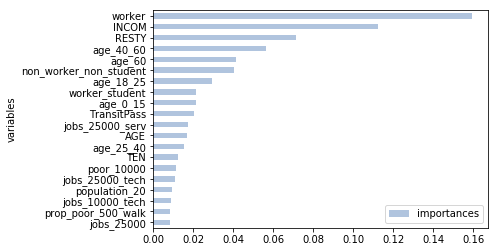

In [15]:
bb = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

bb[-20:].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks();#(fontsize = 10)

In [16]:
pd.crosstab( y_test, model.predict(X_test))

col_0,0,1,2,3
cars_alt,,,,
0,72,109,12,0
1,33,576,242,9
2,11,188,1002,73
3,2,38,320,204


In [17]:
model.score(X_test, y_test)

0.6413005880318229

## Estimation

In [18]:
df_mnl = df[list(bb[bb.importances>bb.importances.mean()].variables)]
df_mnl['cars_alt'] = df['cars_alt']

In [19]:
continous_var = ['jobs_10000_serv', 'sqft_unit_500_walk', 'prop_singles_1500_walk',
                 'avg_hhs_1500_walk', 'jobs_25000', 'prop_poor_500_walk','jobs_10000_tech', 
                 'population_20', 'jobs_25000_tech', 'poor_10000']

dumy_var = ['TransitPass', 'age_0_15','worker_student', 'age_18_25', 'non_worker_non_student', 
            'age_60', 'age_40_60', 'RESTY', 'INCOM', 'worker']

dependet_variable = ['cars_alt']

In [20]:
#Creates 3 dummies for income
#df_mnl['income_0_50k'] = [1 if x<=4 else 0 for x in df_mnl.INCOM]
df_mnl['income_50K_150k'] = [1 if (x>4) & (x<=7) else 0 for x in df_mnl.INCOM]
df_mnl['income_+150K'] = [1 if x>=8 else 0 for x in df_mnl.INCOM]
df_mnl.drop(['INCOM'], axis = 1, inplace = True)

#Creating an intercept
df_mnl['intercept'] = np.ones(df_mnl.shape[0])

In [21]:
x = df_mnl.drop(['cars_alt'], axis = 1)
y = df_mnl.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [22]:
@orca.injectable(autocall=False)
def COM(y, x):
    model = MNLogit(y_train, X_train)
    result = model.fit()
    return result

In [23]:
orca.get_injectable('COM')(y_train, X_train).summary().add_table_params

Optimization terminated successfully.
         Current function value: 0.831409
         Iterations 8


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
Dep. Variable:               cars_alt   No. Observations:                 5867
Model:                        MNLogit   Df Residuals:                     5789
Method:                           MLE   Df Model:                           75
Date:                Wed, 19 Jun 2019   Pseudo R-squ.:                  0.3156
Time:                        16:28:45   Log-Likelihood:                -4877.9
converged:                       True   LL-Null:                       -7127.1
                                        LLR p-value:                     0.000
            cars_alt=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
jobs_10000_serv        -4.403e-06   2.91e-05     -0.151      0.880   -6.14e-05    5.26e-05
sqft_